# Project overview
This project aims to visualize and analyze U.S. COVID-19 data in the time frame from 2020-01-21 to 2022-08-02, as well as predict the number of cases in the following 5 days.

# Data Source

The data are collected from the *New York Times* github repo
https://github.com/nytimes/covid-19-data

# Libraries

In [ ]:
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
# import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (6, 4)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# US nationwide

## Data

In [ ]:
us_covid_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
us_covid_all = pd.read_csv(us_covid_url)
us_covid_all.head()

date  cases  deaths
0  2020-01-21      1       0
1  2020-01-22      1       0
2  2020-01-23      1       0
3  2020-01-24      2       0
4  2020-01-25      3       0

In [ ]:
# convert date column
us_covid_all['date'] = pd.to_datetime(us_covid_all['date'])

# use .diff() to get differences with the preceding row
us_covid_all['daily_new_cases'] = us_covid_all['cases'].diff()
us_covid_all['daily_new_deaths'] = us_covid_all['deaths'].diff()

# use .rolling() to get 7 day avg
us_covid_all['7day_avg_cases'] = us_covid_all['cases'].rolling(window=7, center=True).mean()
us_covid_all['7day_avg_deaths'] = us_covid_all['deaths'].rolling(window=7, center=True).mean()
us_covid_all['7day_avg_new_cases'] = us_covid_all['daily_new_cases'].rolling(window=7, center=True).mean()
us_covid_all['7day_avg_new_deaths'] = us_covid_all['daily_new_deaths'].rolling(window=7, center=True).mean()

In [ ]:
us_covid_all.head()

date  cases  deaths  daily_new_cases  daily_new_deaths  \
0 2020-01-21      1       0              NaN               NaN   
1 2020-01-22      1       0              0.0               0.0   
2 2020-01-23      1       0              0.0               0.0   
3 2020-01-24      2       0              1.0               0.0   
4 2020-01-25      3       0              1.0               0.0   

   7day_avg_cases  7day_avg_deaths  7day_avg_new_cases  7day_avg_new_deaths  
0             NaN              NaN                 NaN                  NaN  
1             NaN              NaN                 NaN                  NaN  
2             NaN              NaN                 NaN                  NaN  
3        2.571429              0.0                 NaN                  NaN  
4        3.142857              0.0            0.571429                  0.0

In [ ]:
us_covid_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 930 non-null    datetime64[ns]
 1   cases                930 non-null    int64         
 2   deaths               930 non-null    int64         
 3   daily_new_cases      929 non-null    float64       
 4   daily_new_deaths     929 non-null    float64       
 5   7day_avg_cases       924 non-null    float64       
 6   7day_avg_deaths      924 non-null    float64       
 7   7day_avg_new_cases   923 non-null    float64       
 8   7day_avg_new_deaths  923 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 65.5 KB


In [ ]:
us_covid_all.describe()

cases        deaths  daily_new_cases  daily_new_deaths  \
count  9.300000e+02  9.300000e+02     9.290000e+02        929.000000   
mean   3.505338e+07  5.185983e+05     9.896601e+04       1108.512379   
std    2.956943e+07  3.398271e+05     1.394784e+05       1000.397823   
min    1.000000e+00  0.000000e+00    -2.399900e+04      -2435.000000   
25%    6.389654e+06  1.909448e+05     2.707700e+04        379.000000   
50%    3.233312e+07  5.752070e+05     5.674600e+04        832.000000   
75%    5.072002e+07  8.050525e+05     1.295010e+05       1616.000000   
max    9.193943e+07  1.029808e+06     1.433977e+06       5463.000000   

       7day_avg_cases  7day_avg_deaths  7day_avg_new_cases  \
count    9.240000e+02     9.240000e+02          923.000000   
mean     3.498277e+07     5.186235e+05        99349.466801   
std      2.941844e+07     3.383827e+05       123946.693480   
min      2.571429e+00     0.000000e+00            0.142857   
25%      6.452113e+06     1.921914e+05        32146.071429   
50%      3.232300e+07     5.749988e+05        65746.000000   
75%      5.051377e+07     8.026404e+05       119442.071429   
max      9.169956e+07     1.028749e+06       806927.857143   

       7day_avg_new_deaths  
count           923.000000  
mean           1114.571119  
std             805.082293  
min               0.000000  
25%             492.785714  
50%             896.428571  
75%            1611.571429  
max            3351.714286

In [ ]:
# choose those before 2022/08/02 as the train set
us_covid = us_covid_all.loc[us_covid_all['date'] <= '2022-08-02'].copy()

In [ ]:
us_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 0 to 924
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 925 non-null    datetime64[ns]
 1   cases                925 non-null    int64         
 2   deaths               925 non-null    int64         
 3   daily_new_cases      924 non-null    float64       
 4   daily_new_deaths     924 non-null    float64       
 5   7day_avg_cases       922 non-null    float64       
 6   7day_avg_deaths      922 non-null    float64       
 7   7day_avg_new_cases   921 non-null    float64       
 8   7day_avg_new_deaths  921 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 72.3 KB


## Visualization

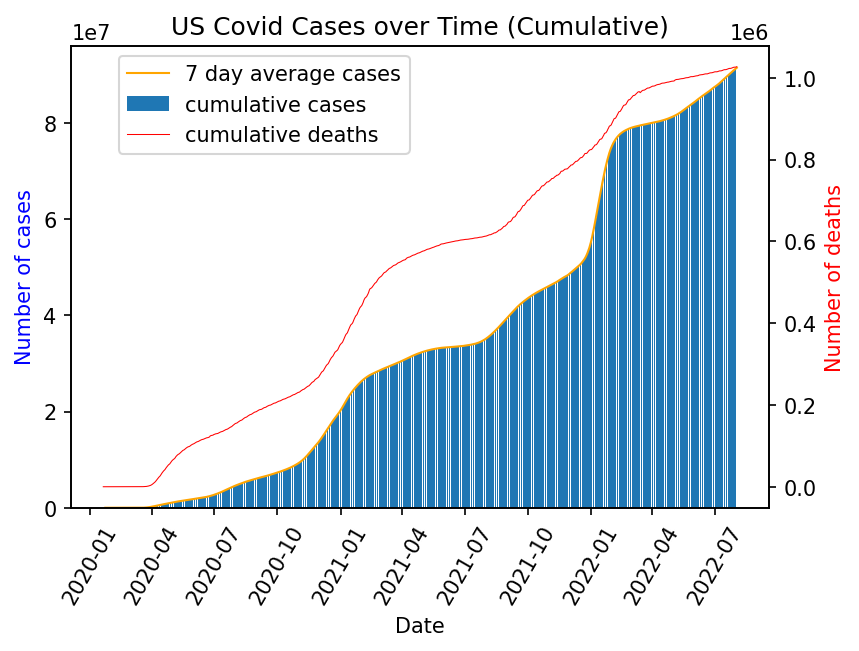

In [ ]:
fig, ax1 = plt.subplots()

ax1.bar(us_covid['date'], us_covid['cases'], label='cumulative cases')
ax1.plot(us_covid['date'], us_covid['7day_avg_cases'], label='7 day average cases', color='orange', lw=1)
ax1.tick_params(axis='x', rotation=60)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of cases', color="blue")

ax2 = ax1.twinx()
ax2.plot(us_covid['date'], us_covid['deaths'], label='cumulative deaths', color='red', lw=0.5)
ax2.set_ylabel('Number of deaths', color='red')

fig.legend(bbox_to_anchor=(0.5,1), bbox_transform=ax2.transAxes)
plt.title('US Covid Cases over Time (Cumulative)')
plt.show()

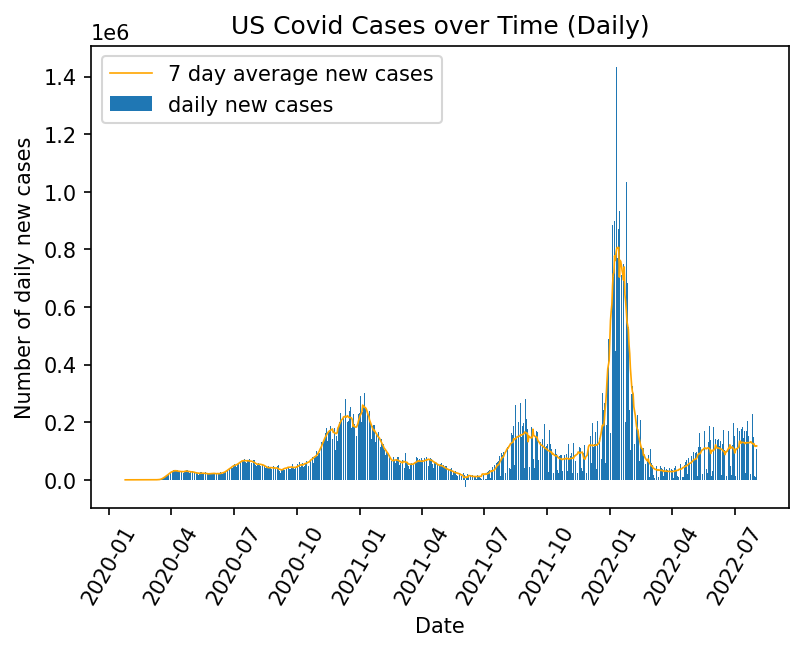

In [ ]:
fig, ax1 = plt.subplots()

ax1.bar(us_covid['date'], us_covid['daily_new_cases'], label='daily new cases')
ax1.plot(us_covid['date'], us_covid['7day_avg_new_cases'], label='7 day average new cases', color='orange', lw=.8)
ax1.tick_params(axis='x', rotation=60)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of daily new cases')

ax1.legend(loc='upper left')
plt.title('US Covid Cases over Time (Daily)')
plt.show()

## Analysis

Arima Assumptions:
1. Data has to be stationary.
2. Data should be univariate.
3. Data should be in time series data format.

Definition of being stationary:
1. Mean has to be constant w.r.t. time.
2. Variance has to be equal w.r.t. time (Homoskedasticity).
3. Covariance has also to be equal.

From the plot below, it is quite obvious that our data is not stationary. We perform an advanced Dicky-Fuller test to confirm.

$H_{0}$: There is a unit root.

$H_{A}$: The time series is stationary.

In [ ]:
def adf_test(data):

  result = adfuller(data)

  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  for key, value in result[4].items():
      print(f'{key}: {value}')

In [ ]:
us_covid_cases = us_covid['cases'].dropna()
adf_test(us_covid_cases)

ADF Statistic: 0.4891992378059946
p-value: 0.9845410923045613
1%: -3.43761244359048
5%: -2.8647460220589736
10%: -2.568477099382028


If p<0.05, we conclude that the time series is not stationary and do the following:
1. We take the log of the time series.
2. We use the differencing method.

If p>0.05, we conclude that the time series is stationary

In [ ]:
us_covid_cases_log = np.log(us_covid['cases'])
us_covid_cases_log_diff = us_covid_cases_log.diff()
us_covid_cases_log_diff.dropna(inplace=True)

adf_test(us_covid_cases_log_diff)

# us_covid_cases_diff = us_covid_cases.diff()
# us_covid_cases_diff.dropna(inplace=True)
# us_covid_cases_diff.describe()

ADF Statistic: -3.1073533446799035
p-value: 0.026013772377800753
1%: -3.437620518167552
5%: -2.8647495822909477
10%: -2.568478995776815


We plot the ACF and PACF of the transformed data.

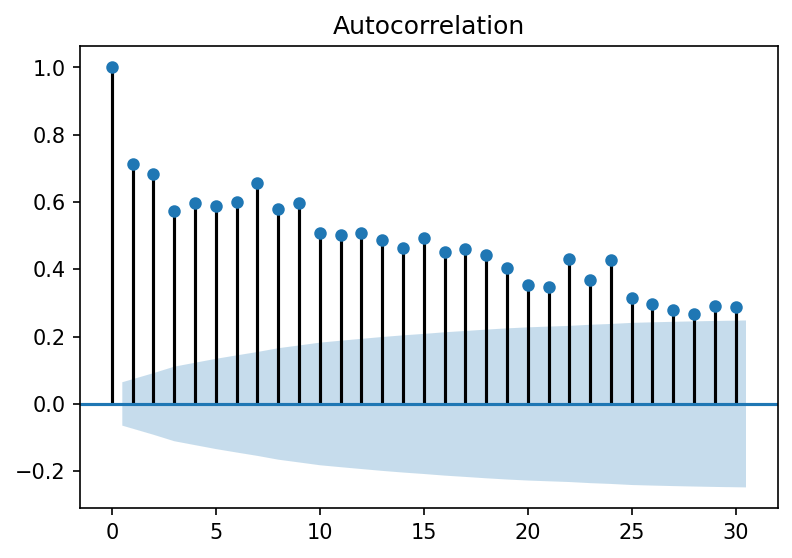

In [ ]:
plot_acf(us_covid_cases_log_diff)

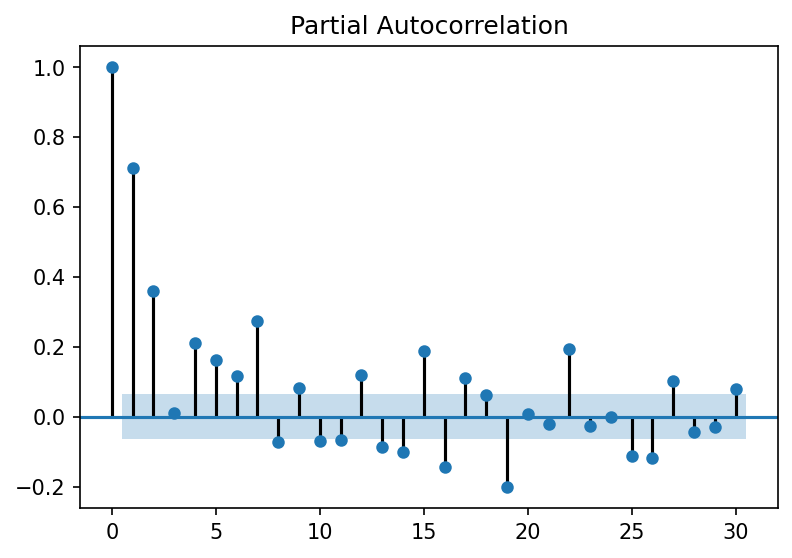

In [ ]:
plot_pacf(us_covid_cases_log_diff)

## ARIMA

$AIC = -2log(L) + 2k$ where $L$ is the likelihood of the data and $k$ is the number of parameters.

*Differencing the data will the change the likelihood ($L$) of the data. The AIC of models with different orders of differencing are therefore not comparable.*

$BIC = -2log(L) + k * log(N), where $N$ is the sample size of the training set and k is the total number of parameters.

In [ ]:
def optimize_ARIMA(data, orders):
    """
    Perform grid search and return dataframe with parameters, AIC and BIC
    
    :params data: data to be fitted
    :params orders: list with (p, d, q) tuples
    """
    
    res = []
    
    for order in orders:
        try: 
            print(order)
            model = ARIMA(data, order=order)
            results = model.fit(disp=-1)
            res.append([order, results.aic, results.bic])
        except:
            continue
            
    res_df = pd.DataFrame(res)
    res_df.columns = ['(p, d, q)', 'AIC', 'BIC']
    res_df.sort_values(by='BIC', ascending=True, inplace=True)
    
    return res_df

In [ ]:
m, n, d = 11, 11, 2

# Create a list with all possible combination of parameters
orders = []
for i in range(1, m):
  for j in range(1, n):
    for k in range(d):
      orders.append(tuple([i, k, j]))
    
res_df = optimize_ARIMA(us_covid_cases_log_diff.values, orders)

(1, 0, 1)
(1, 1, 1)
(1, 0, 2)
(1, 1, 2)
(1, 0, 3)
(1, 1, 3)
(1, 0, 4)
(1, 1, 4)
(1, 0, 5)
(1, 1, 5)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 0, 6)
(1, 1, 6)
(1, 0, 7)
(1, 1, 7)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 0, 8)
(1, 1, 8)
(1, 0, 9)
(1, 1, 9)
(1, 0, 10)
(1, 1, 10)
(2, 0, 1)
(2, 1, 1)
(2, 0, 2)
(2, 1, 2)
(2, 0, 3)
(2, 1, 3)
(2, 0, 4)


In [ ]:
# show the top performing param combinations
res_df.head()

In [ ]:
# fit the model using the optimal params and print the result
model = ARIMA(us_covid_cases_log_diff, order=(5, 1, 10))
results = model.fit(disp=-1)
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.cases   No. Observations:                  923
Model:                ARIMA(5, 1, 10)   Log Likelihood                1963.958
Method:                       css-mle   S.D. of innovations              0.028
Date:                Mon, 08 Aug 2022   AIC                          -3893.915
Time:                        15:57:54   BIC                          -3811.846
Sample:                             1   HQIC                         -3862.602
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0004      0.001     -0.667      0.505      -0.002       0.001
ar.L1.D.cases      0.0786      0.028      2.801      0.005       0.024       0.134
ar.L2.D.cases      0.8532      0.025

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


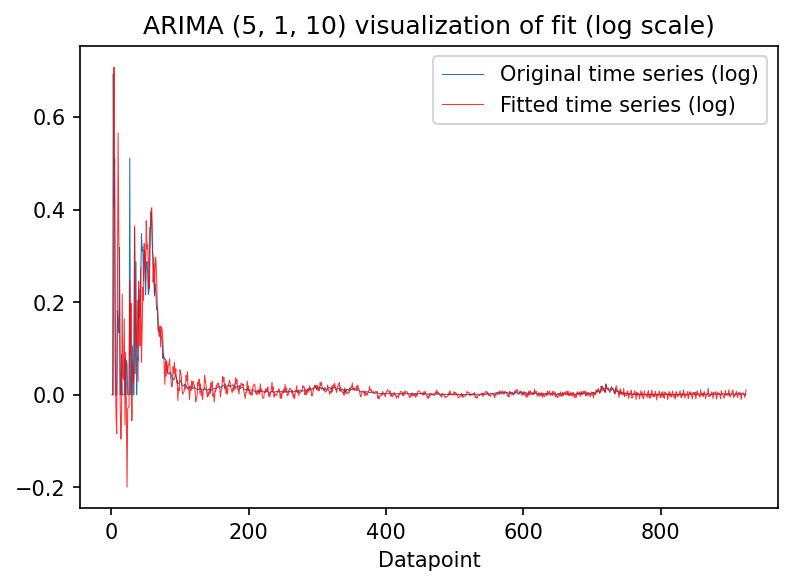

In [ ]:
# visualize model results
plt.close()
plt.plot(us_covid_cases_log_diff, lw=.5, label='Original time series (log)')
plt.plot(results.predict(typ='levels'), color='red', lw=.5, label='Fitted time series (log)', alpha=.8)
plt.xlabel('Datapoint')
plt.title('ARIMA (5, 1, 10) visualization of fit (log scale)')
plt.legend()
plt.show()

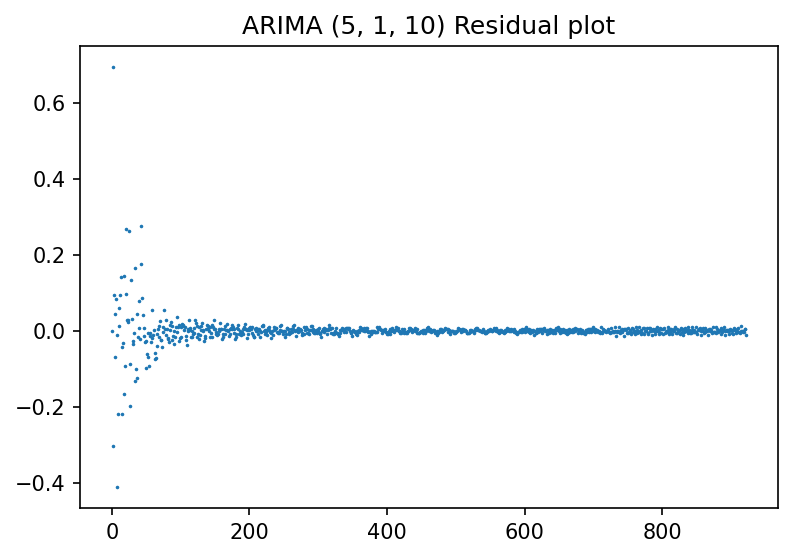

In [ ]:
plt.scatter(range(len(results.resid)), results.resid, label='residuals', s=.5)
plt.title('ARIMA (5, 1, 10) Residual plot')
plt.show()

In [ ]:
rfitted = pd.read_csv('fitted.csv')
rfitted.drop('Unnamed: 0', axis=1, inplace=True)
rfitted.iloc[:, 0]

In [ ]:
# get the fitted values
predictions_ARIMA_diff = results.predict(typ='levels') #rfitted.iloc[:,0]
# revert the .diff() step
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# create a sequence with the original first value (was excluded by .diff())
predictions_ARIMA_log = pd.concat([pd.Series(us_covid_cases_log[0:2]), predictions_ARIMA_diff_cumsum], ignore_index=True)
# revert the .log() step
predictions_ARIMA = np.exp(predictions_ARIMA_log)

In [ ]:
predictions_ARIMA

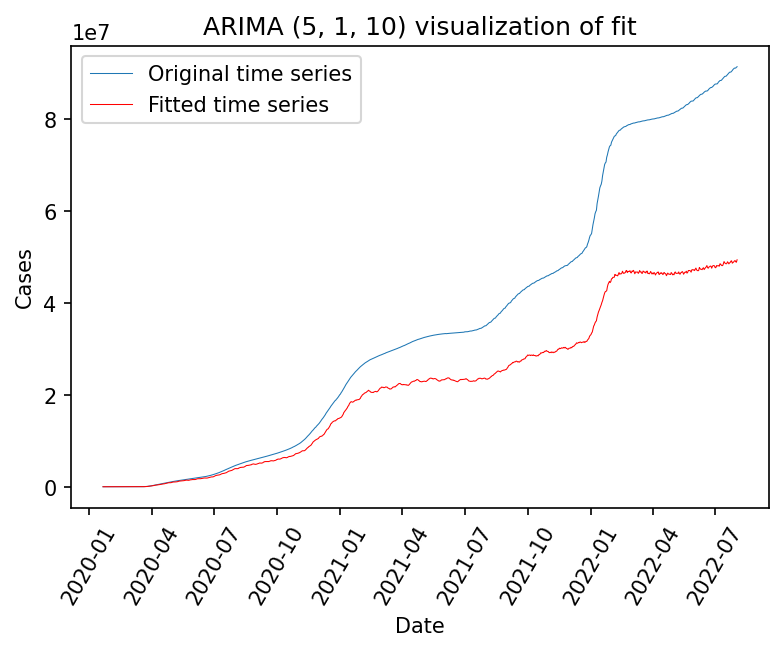

In [ ]:
plt.plot(us_covid['date'], us_covid['cases'], lw=.5, label='Original time series')
plt.plot(us_covid['date'], predictions_ARIMA, color='red', lw=.5, label='Fitted time series')
plt.tick_params(axis='x', rotation=60)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('ARIMA (5, 1, 10) visualization of fit')
plt.legend()
plt.show()

In [ ]:
def arima_predict(start, end):
  predictions = results.predict(start, end, typ='levels')
  train_sum = sum(us_covid_cases_log_diff)
  prediction_df = pd.DataFrame(columns=['actual_cases', 'prediction', 'percent_difference'])
  for i in range(923, end):
    actual_cases = us_covid_all.loc[us_covid_all['date'] == (pd.to_datetime('2022-08-02') + pd.Timedelta(days=(i-923))).strftime('%Y-%m-%d'), 'cases']
    prediction = np.exp(train_sum + predictions[i])
    percent_diff = abs(prediction - actual_cases)/actual_cases
    prediction_df = pd.concat([prediction_df, pd.DataFrame({'actual_cases': actual_cases, 'prediction': prediction, 'percent_difference': percent_diff})])

  return prediction_df.reset_index()


In [ ]:
(pd.to_datetime('2022-08-02') + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

'2022-08-03'

In [ ]:
arima_predict(1, 928)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


index actual_cases    prediction  percent_difference
0    924     91404290  9.161511e+07            0.002306
1    925     91622134  9.158511e+07            0.000404
2    926     91786865  9.096976e+07            0.008902
3    927     91918779  9.051600e+07            0.015261
4    928     91929347  8.987476e+07            0.022350

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


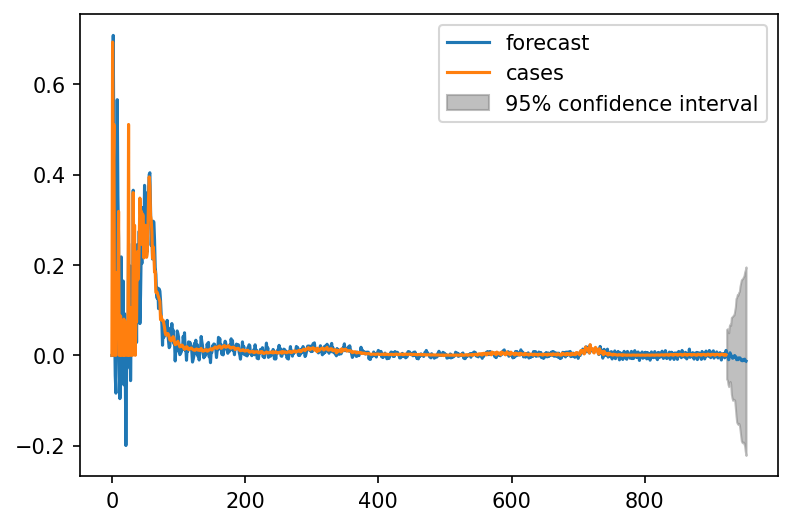

In [ ]:
results.plot_predict(1, 928) # original value 923

# US statewide

## Data

In [ ]:
us_state_covid_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
us_state_covid = pd.read_csv(us_state_covid_url)
us_state_covid.head()

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0

In [ ]:
# convert date column
us_state_covid['date'] = pd.to_datetime(us_state_covid['date'])
us_state_covid = us_state_covid[us_state_covid['date'] <= '2022-08-02']

# sort by state and date
us_state_covid.sort_values(['state', 'date'], inplace=True)

# use .diff() to get differences with the preceding row
us_state_covid['daily_new_cases'] = us_state_covid.groupby('state')['cases'].diff()
us_state_covid['daily_new_deaths'] = us_state_covid.groupby('state')['deaths'].diff()

# use .rolling() to get 7 day avg
# us_state_covid['7day_avg_cases'] = us_state_covid.groupby('state')['cases'].rolling(window=7, center=True).mean().reset_index(drop=True)
# us_state_covid['7day_avg_deaths'] = us_state_covid.groupby('state')['deaths'].rolling(window=7, center=True).mean().reset_index(drop=True)
# us_state_covid['7day_avg_new_cases'] = us_state_covid.groupby('state')['daily_new_cases'].rolling(window=7, center=True).mean().reset_index(drop=True)
# us_state_covid['7day_avg_new_deaths'] = us_state_covid.groupby('state')['daily_new_deaths'].rolling(window=7, center=True).mean().reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}

In [ ]:
# add a state abbrev column
us_state_covid['state_abbrev'] = us_state_covid['state'].apply(lambda x: us_state_to_abbrev[x])

In [ ]:
us_state_covid.head()

date    state  fips  cases  deaths  daily_new_cases  \
586 2020-03-13  Alabama     1      6       0              NaN   
637 2020-03-14  Alabama     1     12       0              6.0   
689 2020-03-15  Alabama     1     23       0             11.0   
742 2020-03-16  Alabama     1     29       0              6.0   
795 2020-03-17  Alabama     1     39       0             10.0   

     daily_new_deaths state_abbrev  
586               NaN           AL  
637               0.0           AL  
689               0.0           AL  
742               0.0           AL  
795               0.0           AL

In [ ]:
us_state_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48894 entries, 586 to 48893
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              48894 non-null  datetime64[ns]
 1   state             48894 non-null  object        
 2   fips              48894 non-null  int64         
 3   cases             48894 non-null  int64         
 4   deaths            48894 non-null  int64         
 5   daily_new_cases   48838 non-null  float64       
 6   daily_new_deaths  48838 non-null  float64       
 7   state_abbrev      48894 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 3.4+ MB


In [ ]:
us_state_covid.describe()

fips         cases        deaths  daily_new_cases  \
count  48894.000000  4.889400e+04  48894.000000     48838.000000   
mean      32.171166  6.573495e+05   9758.856465      1871.580204   
std       18.756446  1.128182e+06  15006.733632      5656.160516   
min        1.000000  1.000000e+00      0.000000    -40527.000000   
25%       17.000000  4.683300e+04    772.000000        38.000000   
50%       31.000000  2.476630e+05   3787.000000       422.000000   
75%       46.000000  7.899398e+05  12193.000000      1591.750000   
max       78.000000  1.075799e+07  93734.000000    227972.000000   

       daily_new_deaths  
count      48838.000000  
mean          21.036508  
std           60.578966  
min        -3770.000000  
25%            0.000000  
50%            4.000000  
75%           19.000000  
max         2559.000000

## Visualization

In [ ]:
us_state_covid_220802 = us_state_covid[us_state_covid['date'] == '2022-08-02']
fig = px.choropleth(us_state_covid_220802, locations='state_abbrev', locationmode="USA-states", hover_name="state",
                    color='cases', hover_data=['cases'], scope="usa", color_continuous_scale="blues",
                    title='US Covid-19 cases by state on 2022-08-02', labels={'cases':'Cumulative cases'})
fig.show()

In [ ]:
top_20_states = us_state_covid_220802.sort_values('cases', ascending=False)['state'].head(20).values
df = us_state_covid[us_state_covid['state'].isin(top_20_states)]

In [ ]:
fig = px.bar(df, x='cases', y="state",
              text='cases', orientation='h', width=700, hover_data=['cases'], animation_frame=df['date'].dt.strftime('%Y-%m-%d'))
fig.update_layout(title='Covid-19 cases Top 20 States', xaxis_title='Cases', yaxis_title="State", 
                  yaxis_categoryorder = 'total ascending')
fig.update_traces(textposition="outside")
for f in fig.frames:
    f.data[0].update(textposition="outside")
    
fig.show()

In [ ]:
fig = px.choropleth(us_state_covid_220802, locations='state_abbrev', locationmode="USA-states", hover_name="state",
                    color='deaths', hover_data=['deaths'], scope="usa", color_continuous_scale="reds",
                    title='US Covid-19 deaths by state on 2022-08-02', labels={'deaths':'Cumulative deaths'})
fig.show()

In [ ]:
top_20_states = us_state_covid_220802.sort_values('deaths', ascending=False)['state'].head(20).values
df = us_state_covid[us_state_covid['state'].isin(top_20_states)]

In [ ]:
fig = px.bar(df, x='deaths', y="state", color_discrete_sequence=['red']*20,
              text='deaths', orientation='h', width=700, hover_data=['deaths'], animation_frame=df['date'].dt.strftime('%Y-%m-%d'))
fig.update_layout(title='Covid-19 deaths Top 20 States', xaxis_title='Deaths', yaxis_title="State", 
                  yaxis_categoryorder = 'total ascending')
fig.update_traces(textposition="outside")
for f in fig.frames:
    f.data[0].update(textposition="outside")

fig.show()

In [ ]:
fig = px.choropleth(us_state_covid, locations="state_abbrev", locationmode="USA-states", hover_name="state",
                    color='daily_new_cases', scope="usa", color_continuous_scale='viridis',
                    animation_frame=us_state_covid['date'].dt.strftime('%Y-%m-%d'),
                    title='US Covid-19 daily new cases over time', labels={'daily_new_cases': 'Daily new cases'})
fig.update(layout_coloraxis_showscale=False)
fig.show()